# Bundesanzeiger Scraping

Der folgende Code scraped die Webseite https://www.bundesanzeiger.de/. 

## Imports:

In [1]:
# for html network requests and parsing:
from bs4 import BeautifulSoup
import requests
# for displaying the captcha images:
from PIL import Image
from io import BytesIO
from IPython.display import display, HTML
from IPython.display import clear_output
# for file importing and exporting:
import csv
import pandas as pd
import json
import os
# for waiting: 
from datetime import datetime
import time
# other:
import re # regex
#from pathlib import Path

import pytesseract
import sys
import argparse


## Globale Variablen:

In [2]:
session_requests = requests.session()
session_id = ""
debug_prints = False

# Funktionen:

## get_search_results

Diese Funktion stellt eine Anfrage an die Suchmaske von https://www.bundesanzeiger.de/ und gibt die Ergebnistabelle als Dataframe zurück.

Diese Funktion wird direkt aufgerufen.

In [71]:
def get_search_results(search_string):
    global session_id
    global debug_prints
    # genericsearch_param.part_id: 22 is for just Jahresabschlüsse
    payload = {'page.navid': 'to_detailsearch', 'global_data.designmode': 'eb', '(page.navid=to_quicksearchlist)': 'Suchen', 'genericsearch_param.part_id': '22', 'genericsearch_param.hitsperpage': '10'}
    payload.update({'genericsearch_param.fulltext': search_string})
    if session_id != "":
        payload.update({'session.sessionid': session_id})

    url = 'https://www.bundesanzeiger.de/ebanzwww/wexsservlet'
    time.sleep(0.33) # wait some seconds before the next request, to not overwhelm the server
    result = session_requests.get(url, params = payload)
    if debug_prints:
        print("get_searchresults url:", result.url)
        print("get_searchresults returned:", result.status_code, result.headers['content-type'])

    # Get html content
    soup = BeautifulSoup(result.text, "lxml")
    # Parse for session id, update variable
    session_id = soup.find('a', href=True)['href']
    session_id = session_id[session_id.find("session.sessionid=")+len("session.sessionid="):session_id.find("&", session_id.find("session.sessionid="))]
    if debug_prints:
        print("session_id:", session_id)

    # Parse html content 
    result_table = soup.find("table", attrs={"class": "result", "summary": "Trefferliste"})
    rows = result_table.find_all("tr")
    table_contents = []
    for tr in rows:
        # header row
        if rows.index(tr) == 0 : 
            row_cells = [ th.getText(separator=" ").strip() for th in tr.find_all('th') if th.getText().strip() != '' ] + ["session.sessionid=", "fts_search_list.selected", "fts_search_list.destHistoryId", "timestamp"] 
        # data rows
        else : 
            # get 'th' element text
            row_cells = ([ tr.find('th').getText(separator=" ") ] if tr.find('th') else [] ) + \
            [ td.getText(separator=" ").strip() for td in tr.find_all('td') if td.getText().strip() != '' ] + \
            [ a['href'][a['href'].find("session.sessionid=")+len("session.sessionid="):a['href'].find("&", a['href'].find("session.sessionid="))] for a in tr.find_all('a', href=True)] + \
            [ a['href'][a['href'].find("fts_search_list.selected=")+len("fts_search_list.selected="):a['href'].find("&", a['href'].find("fts_search_list.selected="))] for a in tr.find_all('a', href=True)] + \
            [ a['href'][a['href'].find("fts_search_list.destHistoryId=")+len("fts_search_list.destHistoryId="):] for a in tr.find_all('a', href=True)] + \
            [ time.ctime() ]
        if len(row_cells) > 1 : 
            table_contents += [ row_cells ]
    
    # Convert to dataframe and set first row as headers
    df = pd.DataFrame.from_dict(table_contents)
    df.columns = df.iloc[0]
    df = df[1:]
    return df

## get_captcha

Bevor eine Dokumentenanfrage mit dem gewünschen Ergebnis beantwortet wird, muss der User ein Captcha lösen. Hier wird die Lösung dem Nutzer gezeigt und seine Eingabe verlangt.

Diese Funktion wird von get_document aufgerufen.

In [72]:
def get_captcha(session_id):
    global debug_prints
    payload = {'state.action':'captcha','captcha_data.mode':'image'}
    payload.update({'session.sessionid': session_id})
    url = 'https://www.bundesanzeiger.de/ebanzwww/contentloader'
    result = session_requests.get(url, params = payload)
    if debug_prints:
        print("get_captcha url", result.url)
        print("get_captcha returned:", result.status_code, result.headers['content-type'])
    
    if result.headers['content-type'] == "image/jpeg":
        img = Image.open(BytesIO(result.content))
        display(img)
        print("script")
        #!python captcha_resolver.py
        solve_captcha(img)
        print("script_done")
        print('Please solve this captcha. To cancel, type "exit"')
        captcha_solution = ""
        captcha_solution = input()
        return captcha_solution
    else:
        print("no image returned")
        return ""

## get_document

Mit dieser Funktion werden Dokumente abgerufen und deren HTML-Inhalt zurückgegeben. Dabei wird auch das vorgeschaltete Captcha beachtet und über get_captcha dem Nutzer gezeigt und abgefragt.

In [73]:
def get_document(search_list_selected, search_list_destHistoryId):
    global session_id
    global debug_prints
    payload = {'page.navid':'detailsearchlisttodetailsearchdetail'}
    payload.update({'session.sessionid': session_id})
    payload.update({'fts_search_list.selected': search_list_selected})
    payload.update({'fts_search_list.destHistoryId': search_list_destHistoryId})
    url = 'https://www.bundesanzeiger.de/ebanzwww/wexsservlet'
    time.sleep(2) # wait 2 seconds before the next request, to not overwhelm the server
    result = session_requests.get(url, params = payload)
    if debug_prints:
        print("get_details url:", result.url)
        print("get_details returned:", result.status_code, result.headers['content-type'])

    # Parse the html content
    soup = BeautifulSoup(result.text, "lxml")
    # Parse for session id, update variable
    session_id = soup.find('a', href=True)['href']
    session_id = session_id[session_id.find("session.sessionid=")+len("session.sessionid="):session_id.find("&", session_id.find("session.sessionid="))]
    # check if page has a captcha
    if soup.find("div", attrs={"class": "image_captcha"}) != None:
        #print("Captcha found")
        captcha_found = True
        captcha_solution = ""
        captcha_solution = get_captcha(session_id)
        #if captcha_solution == "" or captcha_solution == "exit":
        if captcha_solution == "exit":
            # if captcha was not solved
            return "exit"
        else:
            # if captcha was solved, solution will be posted to server and response will be checked for new captcha
            while captcha_found == True:
                # POST captcha solution
                post_payload = {"genericsearch_param.part_id":"","(page.navid=detailsearchdetailtodetailsearchdetailsolvecaptcha)":"OK"}
                post_payload.update({'session.sessionid': session_id})
                post_payload.update({'captcha_data.solution': captcha_solution})
                post_url = 'https://www.bundesanzeiger.de/ebanzwww/wexsservlet'
                result = session_requests.post(post_url, data = post_payload)
                if debug_prints:
                    print("post_captcha url: ", result.url)
                    print("post_captcha returned: ", result.status_code, result.headers['content-type'])
                # Check for captcha again
                soup = BeautifulSoup(result.text, "lxml")
                # Parse for session id, update variable
                session_id = soup.find('a', href=True)['href']
                session_id = session_id[session_id.find("session.sessionid=")+len("session.sessionid="):session_id.find("&", session_id.find("session.sessionid="))]
                # check if page has a captcha again
                if soup.find("div", attrs={"class": "image_captcha"}) != None:
                    print("WRONG captcha, new captcha found -- PLEASE TRY AGAIN")
                    captcha_found = True
                    captcha_solution = ""
                    captcha_solution = get_captcha(session_id)
                    #if captcha_solution == "" or captcha_solution == "exit":
                    if captcha_solution == "exit":
                        return "exit"
                    # ... if a solution was provided by the user, the loop then starts again
                else:
                    captcha_found = False
                    print("Captcha successfully solved!")
                    return soup
                # ... loop starts again 
            return soup
    else:
        return soup

In [74]:
def solve_captcha(image_captcha):
    #try:
     #   import Image
    #except ImportError:
    #    from PIL import Image
    #from subprocess import check_output
    print("solving")

    def resolve(image_captcha):
        print("Resampling the Image")
        check_output([r"C:\Program Files\ImageMagick-7.0.10-Q16-HDRI\magick.exe", image_captcha, '-resample', '600', image_captcha])
        return pytesseract.image_to_string(Image.open(image_captcha))
    display(image_captcha)

    if __name__=="__main__":
        #argparser = argparse.ArgumentParser()
        #argparser.add_argument('path',help = 'Captcha file path')
        #args = argparser.parse_args()
        #path = args.path
        print('Resolving Captcha')
        captcha_text = resolve(image_captcha)
        print('Extracted Text',captcha_text)

# Ausführung:

In den folgenden zwei Abschnitten passiert folgendes: 
* Abschnitt 1: get overview about companies from Kununu scraping
    * Die Liste der Unternehmen eingelesen.
    * Für diese Unternehmen wird die Suchfunktion ausgeführt, um die vorhandenen Dokumente bzw. Jahresabschlüsse zu scrapen.
    * Die jeweiligen Suchergebnisse werden als csv exportiert. 
    
    
* Abschnitt 2: get overview about companies from Insolvency scraping
    * Die Liste der Unternehmen eingelesen.
    * Für diese Unternehmen wird die Suchfunktion ausgeführt, um die vorhandenen Dokumente bzw. Jahresabschlüsse zu scrapen.
    * Die jeweiligen Suchergebnisse werden als csv exportiert. 
    
    
* Abschnitt 3: get documents of companies
    * Die jeweiligen csv-Dateien werden eingelesen.
    * Alle Jahresabschlüsse >= 2018 werden angefordert.
    
* Abschnitt 4: remove invalid documents
    * Manchmal ist die Antwort des Servers, dass etwas fehlerhaft ist. Diese Dateien werden gelöscht.

### get overview about companies from kununu scraping

In [16]:
# Einlesen der Liste aller Unternehmen

with open('C:/Users/Jan/Documents/GitHub/capstone_project/Bundesanzeiger Scraper/Jan/Kopie_company_names_IT.json') as json_file:
    company_names = json.load(json_file) 


debug_prints = False
errors_occured = ""

# for company name sanitizing
keepcharacters = (' ','.','_', '-')

if 'company_names' in globals() or 'company_names' in locals():
    for company in company_names[:100]:
        clear_output(wait=True)
        print("COMPANY:", company_names.index(company)+1, "/", len(company_names), "--", company)
        # get search results
        try:
            if company != "None":
                df = get_search_results(company)
                df.to_csv('scraped_data/KUNUNU_'+"".join(c for c in company if c.isalnum() or c in keepcharacters).rstrip()+".csv", \
                    index=False, encoding='utf-8', sep=';', quoting=csv.QUOTE_ALL)
        except Exception as e:
            errors_occurred = errors_occured + repr(e) + "at company " + company + "\n"
            if debug_prints:
                print('Some Error occured! Continue? y/y')
                print(e)
                test = input()
            pass
    
    print("Done!")
    if errors_occured != "":
        print("The following errors occured:")
        print(errors_occured)

COMPANY: 100 / 11161 -- readdy GmbH
Done!


### get overview about companies from insolvency scraping

In [75]:
#insolvency_companies = pd.read_pickle('../Insolvency Scraper/Insolvency/companies_--+Alle+Bundesl_E4nder+--.pkl')
#insolvency_companies = pd.read_pickle('../Insolvency Scraper/Insolvency/companies_Hessen.pkl')

debug_prints = False
errors_occured = ""
skip_item = False

# for company name sanitizing
keepcharacters = (' ','.','_', '-')
counter = 1


if 'insolvency_companies' in globals() or 'insolvency_companies' in locals():
    for index, row in insolvency_companies.iterrows():
        clear_output(wait=True)
        print("COMPANY:", counter, "/", len(insolvency_companies.index), "--", row['Company Name'])
        counter = counter+1

        # do not check for names!
        if len(row['Company Name'].split()) > 3:
            skip_item = False
        elif ('GmbH' in row['Company Name']) or ('GbR' in row['Company Name']) or \
                ('AG' in row['Company Name']) or ('KG' in row['Company Name']) or ('OHG' in row['Company Name']) or \
                ('SE' in row['Company Name']) or ('KG' in row['Company Name']):
            skip_item = False
        else:
            skip_item = True
            print('skipped!')

        # get search results
        if not skip_item:
            try:
                df = get_search_results(row['Company Name'])
                df.to_csv('scraped_data/INSOLVENCY_'+"".join(c for c in row['Company Name'] if c.isalnum() or c in keepcharacters).rstrip()+".csv", \
                    index=False, encoding='utf-8', sep=';', quoting=csv.QUOTE_ALL)
            except Exception as e:
                errors_occurred = errors_occured +  str(repr(e)) + "\n"
                if debug_prints:
                    print('Some Error occured! Continue? y/y')
                    print(e)
                    test = input()
                pass
        
        
print("Done!")
if errors_occured != "":
    print("The following errors occured:")
    print(errors_occured)

Done!


### get documents of companies

COMPANY: 7 / 106 -- KUNUNU_711media websolutions GmbH.csv
next: 711media websolutions GmbH Stuttgart -- Dokument vom 04.12.2019 -- » Jahresabschluss zum Geschäftsjahr vom 01.01.2018 bis zum 31.12.2018


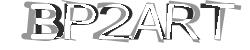

script
solving


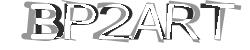

Resolving Captcha
Resampling the Image


TypeError: argument of type 'JpegImageFile' is not iterable

In [76]:
# get list of all files in folder 'scraped_data'
for root, dirs, files in os.walk('scraped_data'):
    document_list = files
    pass

debug_prints = False
abort_execution = False
skip_item = False

regex1 = re.compile(r'bis zum \d{2}\.\d{2}\.(\d{4})')
current_filename = ""
if 'document_list' in globals() or 'document_list' in locals():
    count_of_csvs = len([item for item in document_list if item.endswith('.csv')])
csv_counter = 1

# for company name sanitizing
keepcharacters = (' ','.','_', '-')

if 'document_list' in globals() or 'document_list' in locals():
    for item in document_list:
        clear_output(wait=True)
        print("COMPANY:", csv_counter, "/", count_of_csvs, "--", item)
        if item.endswith('.csv'):   
            try:
                df = pd.read_csv('scraped_data/'+item, sep=";")
                skip_item = False
            except FileNotFoundError:
                print("file not found!")
                skip_item = True
        else:
            skip_item = True

        if not skip_item: 
            csv_counter = csv_counter + 1
            for index, row in df.iterrows():
                if row[0] != "Suche - kein Suchergebnis" and isinstance(row[2], str):
                    # filename like '%searchstring%_%documentdate%.html'
                    current_filename = "".join(c for c in item if c.isalnum() or c in keepcharacters).rstrip()+"_"+row[3]+".html"
                    # if the file for the current document does NOT exist, request it
                    # else, the document will not be requested -- this avoids double work
                    if not os.path.exists(os.path.join('scraped_data', current_filename)):
                        t = regex1.search(row[2])
                        if t is not None:
                            if int(t.group()[-4:]) >= 2018: 
                                print("next:", row[0], "-- Dokument vom", row[3], "--", row[2])
                                # here the document is requested:
                                html_result = get_document(row[6], row[7])
                                if html_result == "exit":
                                    abort_execution = True
                                    print("Execution was aborted!")
                                    break
                                elif html_result != "":
                                    # filename like '%searchstring%_%documentdate%.html'
                                    with open(os.path.join('scraped_data', current_filename), "w", encoding='utf-8') as file:
                                        file.write(str(html_result))
                    else:
                        print("file already exists!")
                else:
                    break
            if abort_execution: 
                break

    
    #   . for loop ends here
            
print("Done!")

### Error Handling: Removing html documents with content "invalid"

In [20]:
# get list of all files in folder 'scraped_data'
for root, dirs, files in os.walk('scraped_data'):
    document_list = files
    
debug_prints = False
abort_execution = False
skip_item = False

count_of_htmls = len([item for item in document_list if item.endswith('.html')])+1
html_counter = 1
deleted_counter = 0

for item in document_list:
    clear_output(wait=True)
    print("Document:", html_counter, "/", count_of_htmls, "--", item)
    
    if item.endswith('.html'):   
        try:
            with open('scraped_data/'+item) as file:
                soup = BeautifulSoup(file)
            skip_item = False
        except Exception as EError:
            print("An Error occured!", repr(EError))
            skip_item = True
    else:
        skip_item = True

    if not skip_item: 
        html_counter = html_counter + 1
        invalid_id = soup.findAll(class_='invalid')
        if invalid_id:
            print('this document is invalid. Will be deleted now')
            try:
                if os.path.isfile('scraped_data/'+item):
                    os.remove('scraped_data/'+item)
                    deleted_counter = deleted_counter+1
            except Exception as e:
                print("An Error occured!", repr(e))
                pass
            
print("Done!")
print("Deleted", deleted_counter, "files because they were invalid.")

NameError: name 'document_list' is not defined